
# Load the Target image

# 1) Segmentation Part

Load the Segmentation model

Predict the segmentation on the whole image

# 2) Clustering

Call the clustering on the segmentation mask of the image using MeanShift Utilities set up with the best w_max / h pair

# 3) Classification
Crop the groups in the image

Create batch(es) from the crops

Load ensemble of classifiers

Compute majority votes.



# Segmentation

In [1]:
import os
from sunscc.nb.load import load_from_dir, load_from_dir2, load_from_dir_new_pl, load_from_cfg
from pathlib import Path
from astropy.io import fits
import skimage.io as io
import numpy as np
import torch 
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib ipympl

from sunscc.dataset import DeepsunSegmentationPredictDataset, get_grid_size, crop_patch
from sunscc.dataset.utils import *
from sunscc.callback import reconstruct_segmentation_image, display_classification_predictions

In [2]:
cwd = Path(os.getcwd())
tmp = cwd.parents[0]
os.environ['SUNSCCDATASET_PATH'] = str(tmp)
print(os.environ['SUNSCCDATASET_PATH'])

input_image = "./UPH20240510080302.FTS"
output_dir = Path('./predictions')

/auto/home/users/n/s/nsayez/sunscc


In [3]:
# segmenter_run_dir = Path(os.environ['SUNSCCDATASET_PATH']+'/outputs/2024-05-08/16-20-50_2013-15_UNet_T375_StepLR_epoch_1_run0')
segmenter_run_dir = Path(os.environ['SUNSCCDATASET_PATH']+'/outputs/2023-01-22/13-15-38_2013-15_UNet_T425_T375_T325_StepLR_epoch_1_run8_SUNSCC')


In [4]:
dataset_overrides = [
        'dataset.test_dataset.transforms=[]', 
    ]
seg_config, seg_model, seg_dm, seg_trainer = load_from_dir_new_pl(
                                    run_path= segmenter_run_dir.resolve(),
                                    # run_path= run_dir,
                                    load_trainer=True,
                                    override = dataset_overrides + [
                                        # Don't create new wandb run when testing/predicting
#                                         f'logger=[{{_target_: pytorch_lightning.loggers.CSVLogger, save_dir: "csv_metrics"}}]',
                                        '~callbacks.LR_monitor',
                                        '~callbacks.wandb',
                                    ]
                                )
# dm.setup()
test_dataloader = seg_dm.test_dataloader()


The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
Lightning automatically upgraded your loaded checkpoint from v1.6.0 to v2.2.4. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../../../../globalscratch/users/n/s/nsayez/outputs/2023-01-22/13-15-38_2013-15_UNet_T425_T375_T325_StepLR_epoch_1_run8_SUNSCC/models/last.ckpt`


BaseSegment
{'_target_': 'sunscc.model.ConfUnet', 'model_cfg': {'_target_': 'sunscc.model.ModelConfig'}, 'architecture': {'first': 32, 'enc': {'width': [32, 64, 128, 256, 512, 512, 512], 'repeat': [1, 1, 1, 1, 1, 1, 1]}, 'dec': {'width': [512, 512, 256, 128, 64, 32], 'repeat': [1, 1, 1, 1, 1, 1]}}, 'input_format': ['image'], 'output_format': ['segmentation'], 'classes': ['sunspot'], 'block': 'double'}
sunscc.loss.CombineLosses
Ignored_indexA: -100  Ignored_indexB: None
['sunspot']
predictions


/home/ucl/elen/nsayez/miniconda3/envs/sunscc/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.1 /home/ucl/elen/nsayez/miniconda3/envs/sunscc/lib/ ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [5]:
# ds = {"_target_": "sunscc.dataset.DeepsunSegmentationPredictDataset", "root_dir": ".", "dtypes":['image'], "patch_side":512, "transforms":None}
# # ds = DeepsunSegmentationPredictDataset(root_dir = ".", dtypes=['image'], patch_side=512, transforms=None)
# dm.set_predict_dataset(ds)
# # dm.setup()
# trainer.predict(model=model, datamodule=dm)
# pass

In [6]:
hdulst:fits.HDUList = fits.open(input_image)
image = hdulst[0]
header = image.header
center = np.array(image.shape)//2
radius = header['SOLAR_R']

patch_side = test_dataloader.dataset.patch_side
grid_size = get_grid_size(input_image, patch_side)

batch_v1 = {}

for index in tqdm(range(grid_size)):

    # print(do_transform)
    sample = {} 
    idx_img = index // grid_size
    idx_patch = index % grid_size

    sample["image"] = crop_patch((image.data).astype(float), idx_patch, patch_side, grid_size) # load image from directory with skimage
    sample['sample_id'] = f'{idx_img}_{idx_patch}'
    sample["name"] = os.path.basename(input_image)


    #####################################
    sample["segmentation"] = np.zeros_like(sample["image"])
    
    batch_v1[idx_patch] = sample

hdulst.close()
print(batch_v1)

  0%|          | 0/16 [00:00<?, ?it/s]

{0: {'image': array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       ...,
       [  44.,   45.,   44., ..., 2572., 2564., 2547.],
       [  45.,   44.,   45., ..., 2545., 2557., 2568.],
       [  47.,   49.,   47., ..., 2542., 2560., 2578.]]), 'sample_id': '0_0', 'name': 'UPH20240510080302.FTS', 'segmentation': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])}, 1: {'image': array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       ...,
       [2547., 2573., 2573., ..., 2908., 2909., 2929.],
       [2565., 2537., 2527., ..., 2921., 2919., 2953.],
       [2579., 2551

       [0., 0., 0., ..., 0., 0., 0.]])}}


In [7]:
keys_to_tensor = ['image', 'segmentation']

batch_v2 = {key: torch.tensor(np.concatenate([d[key][None,:,:] for d in batch_v1.values()])) 
            if key in keys_to_tensor else [d[key] for d in batch_v1.values()] 
            for key in batch_v1[0].keys()}

# for k,v in batch_v2.items():
#     if k in keys_to_tensor:
#         print(f'{k} {v.shape}')
#     else:
#         print(f'{k} {len(v)}')
output_seg = seg_model.predict(batch_v2)
reconstruct_segmentation_image(grid_size, batch_v2, output_seg, output_dir)

In [8]:
seg_mask_fn = output_dir/(os.path.basename(input_image).split(".")[0]+ ".png")
seg_mask = io.imread(seg_mask_fn)

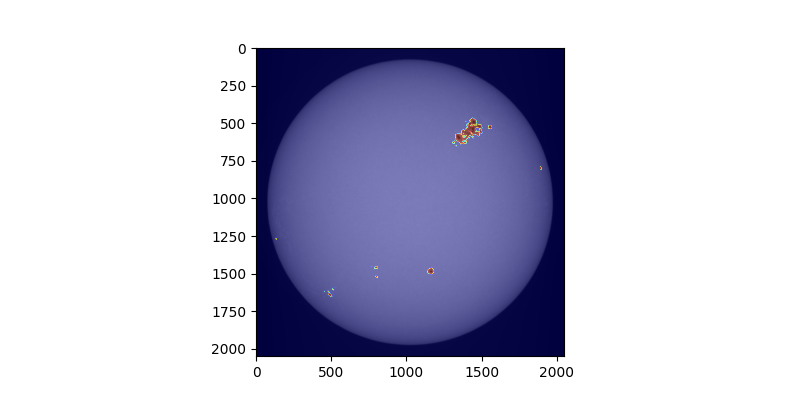

In [9]:
fig  = plt.figure(figsize=(8,4))
ax1 = plt.subplot(1, 1, 1)
ax1.imshow(image.data, cmap='gray', interpolation=None)
# seg_mask[seg_mask == 0] = np.nan
ax1.imshow(seg_mask, cmap='jet', alpha=0.5 )



# Clustering

In [10]:
import sunscc.utils.clustering.clustering_utilities as c_utils

In [11]:
wl_fn , seg_mask_fn = input_image, seg_mask_fn

input_type = 'mask'
Rmm = 126.0
look_distance=0.1
# kernel_bandwidthLon=.35
kernel_bandwidthLon=.45
kernel_bandwidthLat=0.08
n_iterations=20

clustering_key, clustering_dict, (m,h,wcs,seg) = c_utils.process_new_image(wl_fn , seg_mask_fn,
                                                            input_type=input_type, Rmm=Rmm,
                                                             look_distance=look_distance, n_iterations=n_iterations,
                                                             kernel_bandwidthLat=kernel_bandwidthLat,
                                                             kernel_bandwidthLon=kernel_bandwidthLon,
                                                            show=False
                                                            )
# clustering_key, clustering_dict

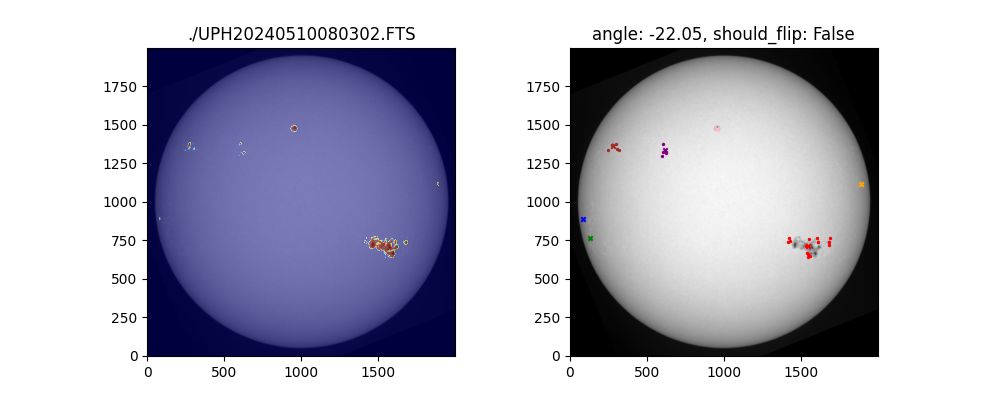

In [12]:

colors = [ "red", "green", "blue", "orange", "purple", "brown", "pink", "gray", "olive", "cyan", "magenta", "yellow"] 

fig3,ax3 = plt.subplots(1,2,figsize=(10,4))

ax3[0].clear(), ax3[1].clear()#, ax3[2].clear()
ax3[0].set_title(input_image)
ax3[0].imshow(m.data,cmap='gray')
ax3[0].imshow(seg,cmap='jet',alpha=0.5)
ax3[0].invert_yaxis()

ax3[1].imshow(m.data,cmap='gray')
ax3[1].invert_yaxis()

ax3[1].set_title(f'angle: {"%.2f" % clustering_dict["SOLAR_P0"]}, should_flip: {clustering_dict["should_flip"]}')
if clustering_dict['seg'] is not {}:
    
    ms_group_sunspots = clustering_dict['meanshift']['groups']
    ms_group_sunspots_px =  clustering_dict['meanshift']['groups_px']
    ms_centers = clustering_dict['meanshift']['centroids_px']
    
    for i in range(len(ms_group_sunspots)):
        c = colors[i%len(colors)]
        cur = np.array(ms_group_sunspots_px[i])
        cur_center = np.array(ms_centers[i])
        
        ax3[1].scatter(cur_center[0],cur_center[1], s=10, c=c, marker='x')
        ax3[1].scatter(cur[:,0], cur[:,1], color=c, s=2)

In [13]:
from sunscc.utils.clustering import matching_utilities as m_utils
from copy import deepcopy

def add_superclasses(group_dict):
    cpy = deepcopy(group_dict)    
    # print(cpy)

    cpy["SuperClass"] = {
        "1": "?",
        "2": "?",
        "3": "?",
    }
    
    return cpy

In [14]:

Rpx = h["SOLAR_R"]
# Rpx = 1480
bn , img_dict = m_utils.find_groups_one_image(wl_fn , seg_mask_fn,
                                            clustering_dict, 
                                            Rpx,
                                            input_type=input_type,
                                            
                                           )
# bn, img_dict

groups = img_dict['groups']
group_based_dataset_superclasses = {}
for i, g in enumerate(groups):
    g['centroid_px'] = [g['centroid_px'][1],g['centroid_px'][0]]
    g['members'] = [[a[1],a[0]] for a in g['members']]
    g['members_mean_px'] = [g['members_mean_px'][1],g['members_mean_px'][0]]
    
    new_group_infos= {
        'angle': img_dict['angle'],
        'deltashapeX': img_dict['deltashapeX'],
        'deltashapeY':img_dict['deltashapeY'],
        'centroid_px': g['centroid_px'],
        'centroid_Lat': g['centroid_Lat'],
        'centroid_Lon': g['centroid_Lon'],
        'members': g['members'],
        'members_mean_px': g['members_mean_px'],
        'angular_excentricity_rad': g['angular_excentricity_rad'],
        'angular_excentricity_deg': g['angular_excentricity_deg'],
        'Zurich': g['Zurich'],
        'McIntosh': g['McIntosh'],   
    }

    new_goup_id = bn + '_' + str(i)
    
    group_based_dataset_superclasses[new_goup_id] = add_superclasses(new_group_infos)

# group_based_dataset_superclasses

0it [00:00, ?it/s]

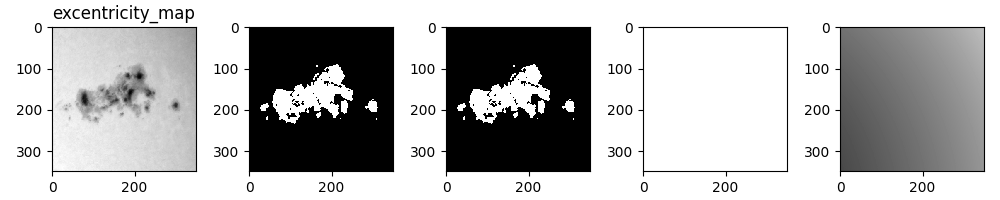

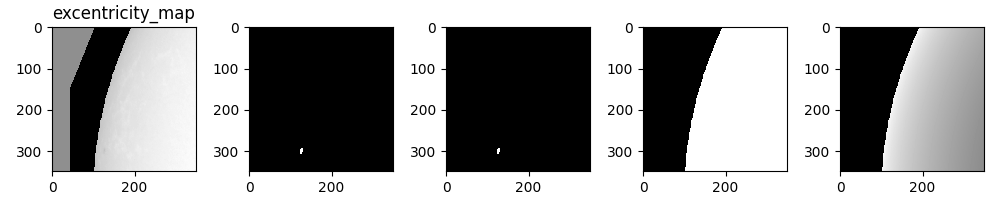

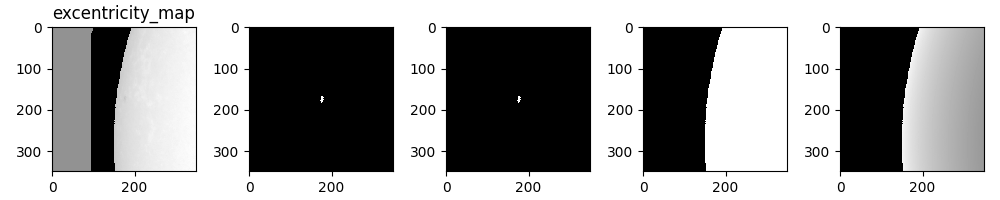

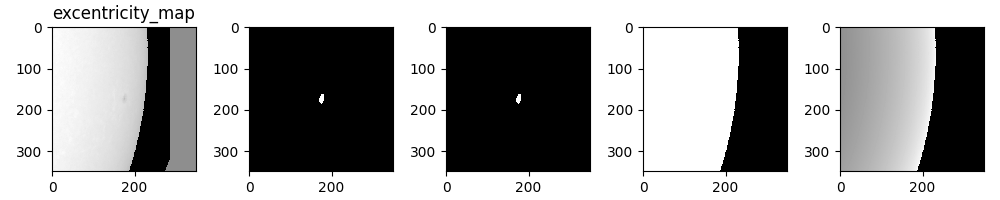

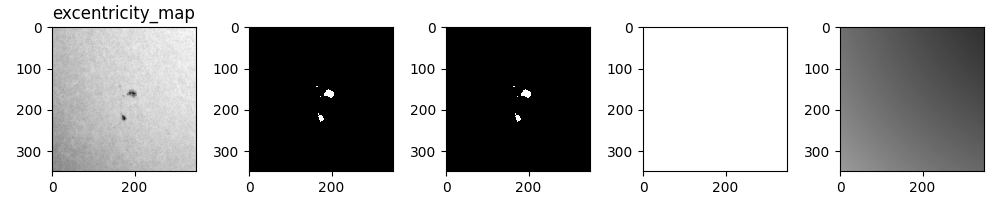

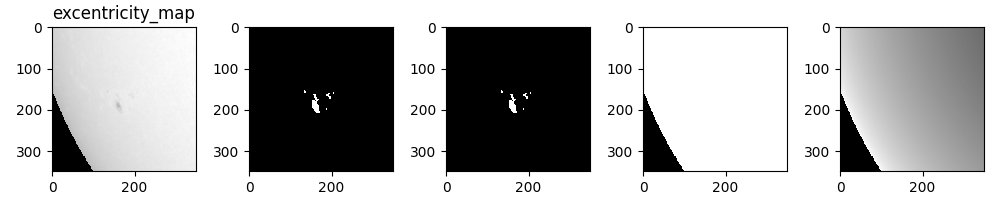

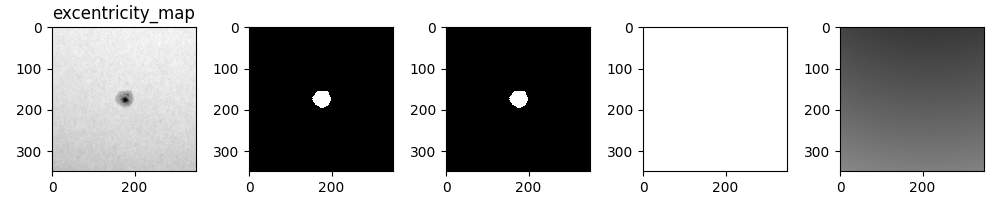

In [15]:
from omegaconf import DictConfig, OmegaConf
from sunscc.dataset.transform.pipelines import Compose
from sunscc.dataset.utils import create_circular_mask, get_sun_mask

classification = 'SuperClass'

transforms_p1 = OmegaConf.load('../sunscc/conf/exp/Classification_Superclasses4.yaml').dataset.train_dataset.transforms
transforms_p1[3].standard_height = 350
transforms_p1[3].standard_width = 350

if isinstance(transforms_p1, collections.abc.Mapping):
    transforms_p1 = partial(call, config=transforms_p1)
elif isinstance(transforms_p1, collections.abc.Sequence):
    transforms_init = []
    for transform in transforms_p1:
        transforms_init.append(instantiate(transform))
    transforms = Compose(transforms_init)
    
classif_samples = {}

for index, (g_k, g_v) in tqdm(enumerate(group_based_dataset_superclasses.items())):
    group_dict = g_v
    basename = g_k.split('_')[0]
    
    sample = {} 
    
#     sample['solar_disk'] = io.imread(self.files[basename]["sun_mask"])
    basic_mask = create_circular_mask( image.shape[0], image.shape[1] ,center,radius=radius*1.03)
    sample['solar_disk'] = get_sun_mask( image.data, basic_mask, radius)
    
    sample['excentricity_map'] = create_excentricity_map(sample['solar_disk'], radius, value_outside=-1)
    sample['mask'] = io.imread(seg_mask_fn)
    sample['confidence_map'] = io.imread(seg_mask_fn)

    sample['image'] = (image.data).astype(float)

    sample['members'] = np.array(group_dict['members']) if 'members' in group_dict else np.array([0])
    sample['members_mean_px'] = np.array(group_dict['members_mean_px']) if 'members_mean_px' in group_dict else np.array([0])

    sample['name'] = basename
    sample['group_name'] = g_k

    sample['solar_angle'] = group_dict['angle']
    sample['deltashapeX'] = group_dict['deltashapeX']
    sample['deltashapeY'] = group_dict['deltashapeY']

    sample['angular_excentricity'] = np.array([group_dict["angular_excentricity_deg"]])
    sample['centroid_px'] = np.array(group_dict["centroid_px"])
    sample['centroid_Lat'] = np.array([group_dict["centroid_Lat"]])

    sample['class1'] = group_dict["SuperClass"]['1']
    sample['class2'] = group_dict["SuperClass"]['2']
    sample['class3'] = group_dict["SuperClass"]['3']
    
    if transforms is not None:
        sample = transforms(**sample)
        
    fig,ax = plt.subplots(1, 5, figsize=(10, 2) )
    ax[0].imshow(sample["image"], cmap='gray', interpolation='none')
    ax[0].set_title('Image')
    ax[1].imshow(sample["mask"], cmap='gray', interpolation='none', vmin=0, vmax=1)
    ax[0].set_title('mask')
    ax[2].imshow(sample["confidence_map"], cmap='gray', interpolation='none', vmin=0, vmax=1)
    ax[0].set_title('confidence_map')
    ax[3].imshow(sample["solar_disk"], cmap='gray', interpolation='none', vmin=0, vmax=1)
    ax[0].set_title('solar_disk')
    ax[4].imshow(sample["excentricity_map"], cmap='gray', interpolation='none', vmin=0, vmax=1)
    ax[0].set_title('excentricity_map')
    fig.tight_layout()
        
    center  = sample['image'].shape[0]//2 , sample['image'].shape[1]//2
    slice_x = center[0]-( 256 //2 ), center[0]+ (256 //2 )
    slice_y = center[1]-( 256 //2 ), center[1]+ (256 //2 )
    center_region = sample['confidence_map'][slice_x[0]:slice_x[1], slice_y[0]:slice_y[1]]
    if np.sum(center_region) == 0:
        print('skipping sample', index)
        sample = None
    
    if sample is not None:
        if sample['group_name'] not in classif_samples:
            classif_samples[sample['group_name']] = sample

    
    
    

# Classification

In [16]:
classifier_run_dir = Path(os.environ['SUNSCCDATASET_PATH']+'/outputs/rebuttal/SUNSCC_AllRevisedFiltered_Rebuttal_WithHideNoAug_0.0_class1_100epochs_run21')
classifier_ckpt_path = classifier_run_dir / 'models' / 'ENCODER_MLP1_MLP2_MLP3.ckpt'
print(classifier_run_dir)


/auto/home/users/n/s/nsayez/sunscc/outputs/rebuttal/SUNSCC_AllRevisedFiltered_Rebuttal_WithHideNoAug_0.0_class1_100epochs_run21


In [17]:
dataset_overrides = [
#         'dataset.test_dataset.transforms=[]', 
    ]
# config, model, dm, trainer = load_from_dir_new_pl(
classif_config, classif_model, classif_dm, _ = load_from_dir2(
                                    run_path= classifier_run_dir.resolve(),
                                    # run_path= run_dir,
                                    model_path= classifier_ckpt_path.resolve(),
                                    load_trainer=False,
                                    override = dataset_overrides + [
                                        # Don't create new wandb run when testing/predicting
#                                         f'logger=[{{_target_: pytorch_lightning.loggers.CSVLogger, save_dir: "csv_metrics"}}]',
                                        f'logger=[]',
                                        '~callbacks.LR_monitor',
                                        '~callbacks.wandb',
                                    ]
                                )
# dm.setup()
test_dataloader = classif_dm.test_dataloader()

first_classes = classif_config.first_classes
second_classes = classif_config.second_classes
third_classes = classif_config.third_classes

c1_mapper = {c: i for i,c in enumerate(first_classes)}
c2_mapper = {c: i for i,c in enumerate(second_classes)}
c3_mapper = {c: i for i,c in enumerate(third_classes)}

Lightning automatically upgraded your loaded checkpoint from v1.6.0 to v2.2.4. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../../../../globalscratch/users/n/s/nsayez/outputs/rebuttal/SUNSCC_AllRevisedFiltered_Rebuttal_WithHideNoAug_0.0_class1_100epochs_run21/models/ENCODER_MLP1_MLP2_MLP3.ckpt`


{'_target_': 'sunscc.model.McIntoshClassifier_Generic', 'input_format': {'visual': ['image', 'excentricity_map'], 'numeric': []}, 'output_format': ['class1', 'class2', 'class3'], 'classes': ['A', 'B', 'C', 'SuperGroup', 'H'], 'first_classes': ['A', 'B', 'C', 'SuperGroup', 'H'], 'second_classes': ['x', 'r', 'sym', 'asym'], 'third_classes': ['x', 'o', 'frag'], 'cascade': True, 'double_encoder': False, 'num_channels_offset': 0, 'architecture': {'encoder': {'type': 'new_resnet', 'resnet_version': 34, 'pretrained': True, 'in_channels': 2}, 'MLP1': [512, 256, 256, 128], 'MLP2': [512, 256, 256, 128], 'MLP3': [512, 256, 256, 128]}, 'focus_on_largest_sunspot': True, 'parts_to_train': ['MLP3']}
McIntoshClassifier_Generic
['image', 'excentricity_map'] ///// .  /////////
new_resnet 2 <class 'sunscc.model.NewResnet.ResBlock'> [3, 4, 6, 3]
in_feats 512
self.fc1_input_size 512
self.fc2_input_size 517
self.fc3_input_size 517
['MLP3']
encoder -> requires_grad = False
MLP1 -> requires_grad = False
MLP2 

In [18]:
transforms_p2 = OmegaConf.load(classifier_run_dir/'.hydra'/'config.yaml').dataset.test_dataset.transforms

if isinstance(transforms_p2, collections.abc.Mapping):
    transforms_p2 = partial(call, config=transforms_p2)
elif isinstance(transforms_p2, collections.abc.Sequence):
    transforms_init = []
    for transform in transforms_p2:
        transforms_init.append(instantiate(transform))
    transforms = Compose(transforms_init)

batch_v0 = classif_samples
batch_v1 = {}
if transforms is not None:
    for k, sample in batch_v0.items():
        sample = transforms(**sample)
        batch_v1[k] = sample

# batch_v1 = classif_samples

batch_keys = list(batch_v1.keys())
sample_keys = list(batch_v1[batch_keys[0]].keys())
print(sample_keys)
# print(batch_v1)
keys_to_tensor = ['image', 'excentricity_map', 'solar_disk', 'mask', 'group_mask', 'confidence_map', 'group_confidence_map']

batch_v2 = {key: torch.tensor(np.concatenate([d[key][None,None,:,:] for d in batch_v1.values()])) 
            if key in keys_to_tensor else [d[key] for d in batch_v1.values()] 
            for key in sample_keys}

# for k,v in batch_v2.items():
#     if k in keys_to_tensor:
#         print(f'{k} {v.shape}')
#     else:
#         print(f'{k} {len(v)}')


['solar_disk', 'excentricity_map', 'mask', 'confidence_map', 'image', 'members_mean_px', 'name', 'group_name', 'angular_excentricity', 'centroid_px', 'centroid_Lat', 'class1', 'class2', 'class3', 'group_mask', 'group_confidence_map']


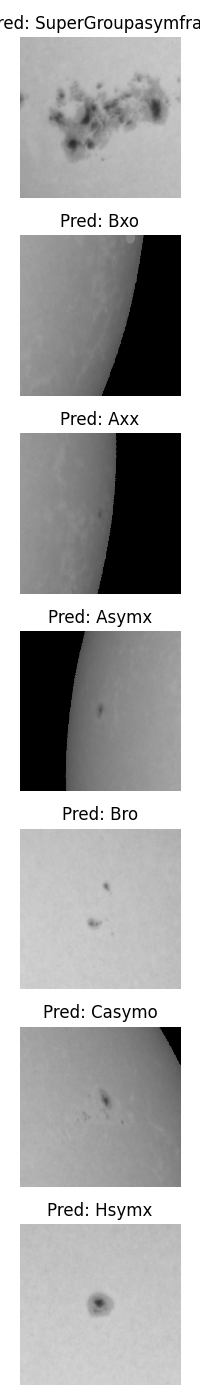

In [ ]:
classif_batch = batch_v2

output_classif = classif_model.predict(classif_batch)
# print(output_classif)
display_classification_predictions(classif_batch, output_classif, c1_mapper,c2_mapper,c3_mapper)
# print(output_classif)

# Playground

In [ ]:
# bioblue_version = torch.load(segmenter_run_dir/'models'/'last_bioblue.ckpt')
# print(bioblue_version)

In [ ]:
# from omegaconf import DictConfig

# def replace_substring_in_dict(d, old_substring, new_substring):
#     for key, value in d.items():
# #         print(key, value)
#         if (isinstance(value, dict) or isinstance(value, DictConfig)):
#             replace_substring_in_dict(value, old_substring, new_substring)
#         elif isinstance(value, str):
# #             print(d[key])
#             d[key] = value.replace(old_substring, new_substring)
#         else:
# #             print(type(value))
#             pass
        
# # print(bioblue_version.keys())
# # print()
# # print(bioblue_version['hyper_parameters'])
# # print()
# sunscc_version = deepcopy(bioblue_version)
# # print(bioblue_hparams)
# # print()

# replace_substring_in_dict(sunscc_version, 'bioblue', "sunscc")
# # print()
# print(sunscc_version['hyper_parameters'])
# print()
# print(bioblue_version['hyper_parameters'])

In [ ]:
# torch.save(sunscc_version, segmenter_run_dir/'models'/'last.ckpt')